In [33]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

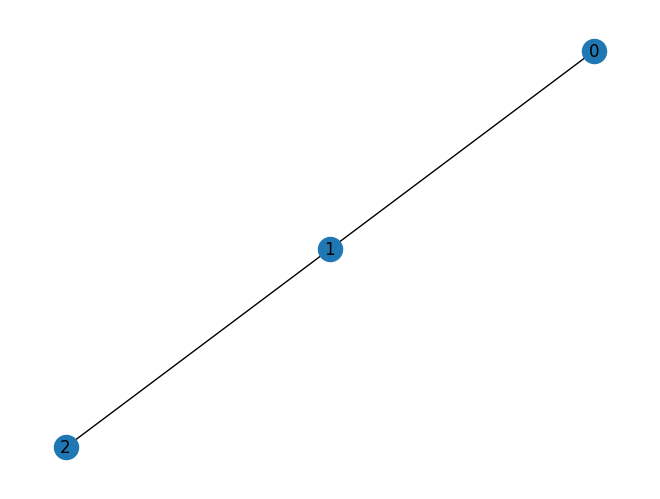

In [34]:
# Parametri
n_nodes = 3
k_colors = 2
edges = [(0, 1), (1, 2)] 
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)
nx.draw(graph, with_labels=True, pos=positions)
plt.show()


In [35]:
n_qubits = n_nodes * k_colors
wires = list(range(n_qubits))

# Mappa nodo-colore → qubit
def qubit_index(node, color):
    return node * k_colors + color


In [36]:
# Hamiltoniano di costo
cost_h = 0

# Penalità: ogni nodo deve avere un solo colore
for node in range(n_nodes):
    terms = []
    for color in range(k_colors):
        wire = qubit_index(node, color)
        terms.append((qml.Identity(wire) - qml.PauliZ(wire)) / 2)
    # Somma dei bit attivati
    sum_x = terms[0]
    for t in terms[1:]:
        sum_x += t
    # (sum - 1)^2 = sum^2 - 2sum + 1
    cost_h += sum_x @ sum_x - 2 * sum_x + 1


# Penalità: nodi adiacenti non devono avere lo stesso colore
for (u, v) in edges:
    for color in range(k_colors):
        i = qubit_index(u, color)
        j = qubit_index(v, color)

        penalty = (1 - qml.PauliZ(i)) / 2 @ (1 - qml.PauliZ(j)) / 2
        cost_h += penalty


In [37]:
# Hamiltoniano di mixer
mixer_h = 0
for qubit in wires:
    mixer_h += qml.PauliX(qubit)


In [38]:
# QAOA Layer
def qaoa_layer(gamma, alpha):
    qml.ApproxTimeEvolution(cost_h, gamma, 1)
    qml.ApproxTimeEvolution(mixer_h, alpha, 1)


In [39]:
# Circuito
depth = 3   
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


In [40]:
# Device
dev = qml.device("qulacs.simulator", wires=n_qubits)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)


In [41]:
# Ottimizzazione
optimizer = qml.GradientDescentOptimizer()
#optimizer = qml.AdamOptimizer()
steps = 100
params = np.array([[0.5] * depth, [0.5] * depth], requires_grad=True)

patience = 3           
min_delta = 0.01        
counter = 0
cost_history = []
best_cost = np.inf
best_params = None

for step in tqdm(range(steps), desc="Training Progress"):
    cost = cost_function(params)
    cost_history.append(cost)

    # Early stopping logic
    if best_cost - cost > min_delta:
        best_cost = cost
        best_params = params.copy()
        counter = 0
    else:
        counter += 1

    # Check stop condition
    if counter >= patience:
        print(f"Early stopping at step {step}")
        break

    params = optimizer.step(cost_function, params)

print("Miglior costo trovato:", best_cost)
print("Parametri corrispondenti:", best_params)

Training Progress:  59%|█████▉    | 59/100 [01:21<00:56,  1.37s/it]

Early stopping at step 59
Miglior costo trovato: 0.8181915441358849
Parametri corrispondenti: [[ 0.52677061  0.59464329 -0.50699951]
 [-0.21570991  0.66915754  0.69524759]]


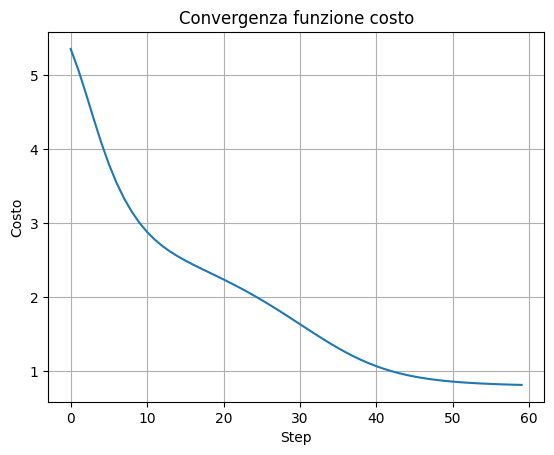

In [42]:
# Plot convergenza
plt.plot(cost_history)
plt.title("Convergenza funzione costo")
plt.xlabel("Step")
plt.ylabel("Costo")
plt.grid(True)
plt.show()

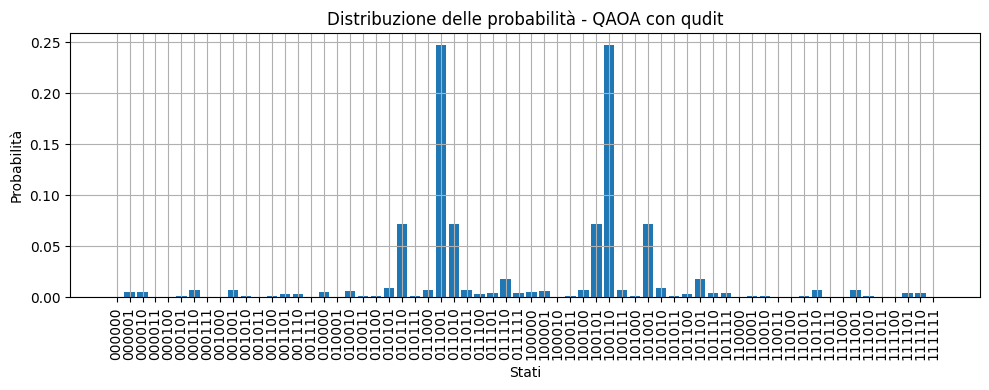

In [43]:
# Probabilità finali
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(best_params[0], best_params[1])

# Istogramma 
bitstrings = [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]

plt.figure(figsize=(10, 4))
plt.bar(bitstrings, probs)
plt.xticks(rotation=90)
plt.xlabel("Stati")
plt.ylabel("Probabilità")
plt.title("Distribuzione delle probabilità - QAOA con qudit")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
def decode_bitstring(bitstring, n_nodes, k_colors):
    assignment = {}
    for node in range(n_nodes):
        for color in range(k_colors):
            index = node * k_colors + color
            if bitstring[index] == '1':
                if node in assignment:
                    assignment[node].append(color)
                else:
                    assignment[node] = [color]
    return assignment

def is_valid_coloring(assignment, edges):
    # Ogni nodo deve avere esattamente un colore
    for node, colors in assignment.items():
        if len(assignment) != n_nodes or len(colors) != 1:
            return False
    # Nodi adiacenti non devono avere lo stesso colore
    for u, v in edges:
        color_u = assignment.get(u, [-1])[0]
        color_v = assignment.get(v, [-2])[0]
        if color_u == color_v:
            return False
    return True

def analyze_results(probs, n_nodes, k_colors, edges, threshold=np.max(probs)-0.00005):
    print("Bitstring | Assegnamento | Valido | Probabilità")
    print("-" * 50)
    outcome = False
    deg = 0
    for idx, prob in enumerate(probs):
        if prob > threshold:
            bitstring = format(idx, f"0{n_nodes * k_colors}b")
            assignment = decode_bitstring(bitstring, n_nodes, k_colors)
            valid = is_valid_coloring(assignment, edges)
            print(f"{bitstring} | {assignment} | {valid} | {prob:.4f}")
            if valid:
                outcome = True
                deg += 1
    return assignment, outcome, deg

assignment, outcome, deg = analyze_results(probs, n_nodes, k_colors, edges)

Bitstring | Assegnamento | Valido | Probabilità
--------------------------------------------------
011001 | {0: [1], 1: [0], 2: [1]} | True | 0.2470
100110 | {0: [0], 1: [1], 2: [0]} | True | 0.2470


In [45]:
#Output: numero cromatico
if outcome:
    print(f"Il numero minimo di colori per colorare il grafo è {k_colors} e si può fare in {deg} modi diversi")
else:
    print(f"{k_colors} NON è il numero cromatico del grafo")

Il numero minimo di colori per colorare il grafo è 2 e si può fare in 2 modi diversi


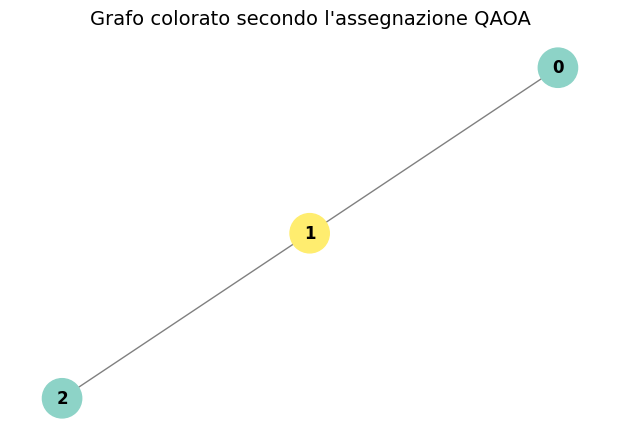

In [46]:
# Visualizzazione grafo colorato
def plot_colored_graph(graph, assignment, positions=None, cmap=plt.cm.Set3):
    # Assumiamo che ogni nodo abbia un solo colore
    node_colors = [assignment[n][0] if len(assignment[n]) == 1 else -1 for n in graph.nodes]

    # Crea un elenco dei colori unici
    unique_colors = sorted(set(c for c in node_colors if c != -1))
    
    # Associa ad ogni colore un colore dalla colormap
    n_colors = len(unique_colors)
    color_list = [cmap(i / max(1, n_colors - 1)) for i in range(n_colors)]
    color_map = {c: color_list[i] for i, c in enumerate(unique_colors)}

    # Assegna il colore o grigio se colore non valido
    final_colors = [color_map.get(c, (0.7, 0.7, 0.7)) for c in node_colors]

    if positions is None:
        positions = nx.spring_layout(graph, seed=42)

    plt.figure(figsize=(6, 4))
    nx.draw(
        graph,
        pos=positions,
        with_labels=True,
        node_color=final_colors,
        edge_color="gray",
        cmap=cmap,
        node_size=800,
        font_color="black",
        font_weight="bold"
    )
    plt.title("Grafo colorato secondo l'assegnazione QAOA", fontsize=14)
    plt.axis('off')
    plt.show()

plot_colored_graph(graph, assignment, positions)